<a href="https://colab.research.google.com/github/Poxiicate/Network-traffic-analysis/blob/main/Network_traffic_Kia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Traffic analysis by Kia

## Pip installations

In [ ]:
!pip install kaggle --quiet

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git

!python rapidsai-csp-utils/colab/pip-install.py

## Data Extraction by API


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ravikumargattu/network-traffic-dataset
!unzip network-traffic-dataset.zip


## Install libraries

In [ ]:
import cudf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

## Data first view and details

In [ ]:
df = pd.read_csv("/content/Midterm_53_group.csv")
df
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394136 entries, 0 to 394135
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         394136 non-null  float64
 1   Source       394136 non-null  object 
 2   No.          394136 non-null  int64  
 3   Destination  394136 non-null  object 
 4   Protocol     394136 non-null  object 
 5   Length       394136 non-null  int64  
 6   Info         394136 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 21.0+ MB


,Time,Source,No.,Destination,Protocol,Length,Info
0,0.000000,192.167.8.166,1,192.167.255.255,NBNS,92,Name query NB WPAD<00>
1,0.784682,192.167.8.166,2,192.167.255.255,NBNS,92,Name query NB WPAD<00>
2,1.169060,VMware_8a:5c:e6,3,Broadcast,ARP,60,Who has 192.167.7.175? Tell 192.167.0.1
3,2.167949,VMware_8a:5c:e6,4,Broadcast,ARP,60,Who has 192.167.7.175? Tell 192.167.0.1
4,3.170095,VMware_8a:5c:e6,5,Broadcast,ARP,60,Who has 192.167.7.175? Tell 192.167.0.1


* We don’t have any missing records, so we can skip the missing value handling step during data preprocessing.

### Checking records of the features

In [ ]:
for col in df.columns:
    print(f"Columns: {col}")
    print(df[col].unique())
    print("-" * 50)

Columns: Time
[0.00000000e+00 7.84682000e-01 1.16906000e+00 ... 1.25599321e+03
 1.25692123e+03 1.25692201e+03]
--------------------------------------------------
Columns: Source
['192.167.8.166' 'VMware_8a:5c:e6' 'VMware_8a:a0:c6' '192.167.6.248'
 'fe80::a4bd:8816:f7b7:d782' '192.167.8.160' '192.167.8.170' '0.0.0.0'
 'VMware_8a:65:fb' '192.167.7.175' '192.167.8.65' '192.167.7.157'
 'VMware_8a:3f:d9' 'VMware_8a:58:7a' 'VMware_8a:72:75' '192.167.7.162'
 '192.167.7.164' '192.167.8.190' '192.167.2.54' '192.167.6.180'
 '192.167.8.174' '192.167.5.117' '192.167.5.122' '192.167.7.47'
 '192.167.7.197' '192.167.7.156' 'VMware_8a:5a:27'
 'fe80::5e28:a543:7b77:3a44' '192.167.6.176' '192.167.8.169'
 'VMware_8a:5f:24' 'VMware_8a:3d:3f' 'VMware_8a:39:a9' '10.27.3.2'
 '34.160.144.191' '23.35.70.176' '34.149.100.209' '34.117.65.55'
 '142.250.191.234' '142.250.191.227' '54.214.185.83' '192.229.211.108'
 '172.217.5.14' '142.250.190.150' '142.250.190.42' '142.250.190.131'
 '142.251.32.13' '172.217.0.162' 

* This dataset has 7 features and over 390,000 records. Let's start by looking at the data types of the features.


# Data type, meaning, and first visualisation

### Feature: Time

* **Time**: This represents the exact time when the network packet starts being recorded, measured in seconds. The current data type is `float64`, which is more precise than needed. We should convert it to `float16` or `float32` to save memory.


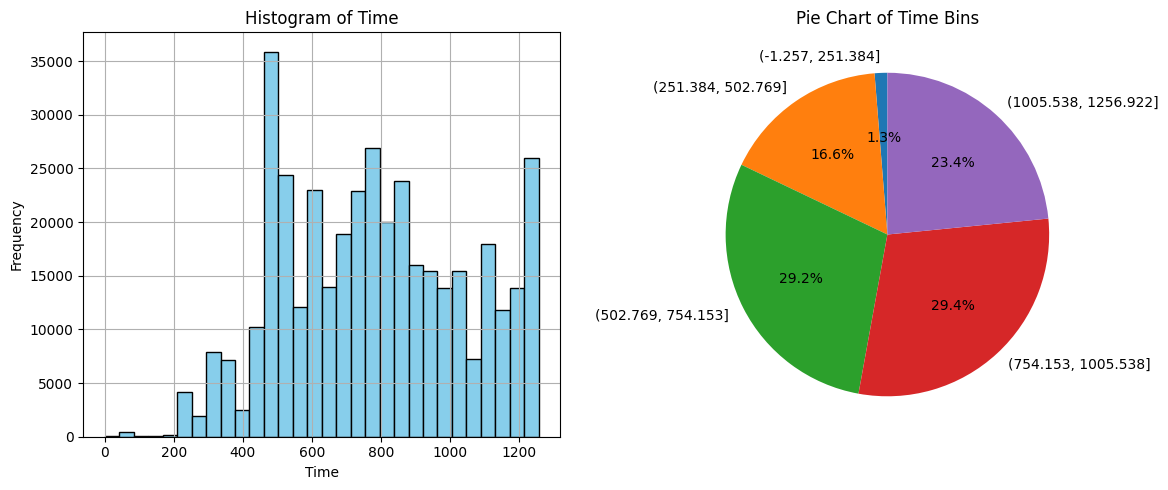

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['Time'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Time')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.grid(True)

bins = 5
time_bins = pd.cut(df['Time'].dropna(), bins=bins)
counts = time_bins.value_counts().sort_index()

plt.subplot(1, 2, 2)
plt.pie(counts.values, labels=[str(interval) for interval in counts.index], autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart of Time Bins')

plt.tight_layout()
plt.show()


* As you can see, the **Time** feature does not follow a normal distribution. Most of the records fall between 450 seconds and 1,250 seconds.


## Feature: Source

* The Source feature contains the sender's IP or MAC address. It's an important feature because it allows us to analyze which IP sends the most packets. The data type is object, which is suitable due to the varying lengths and formats of the values.

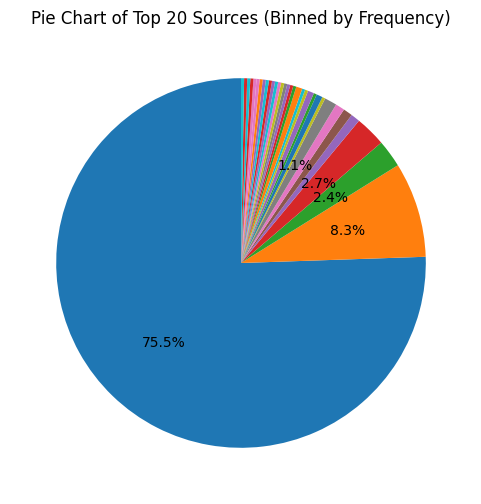

In [ ]:
top_sources = df['Source'].value_counts()

binned = pd.cut(top_sources.values, bins=1000)
binned_counts = pd.Series(binned).value_counts().sort_index()

def autopct_filter(pct):
    return f'{pct:.1f}%' if pct >= 1 else ''

plt.figure(figsize=(6, 6))
plt.pie(
    binned_counts.values,
    labels=None,
    autopct=autopct_filter,
    startangle=90
)
plt.title('Pie Chart of Top 20 Sources (Binned by Frequency)')
plt.show()


* A histogram is not a good choice for this feature because there are too many unique values. However, the pie chart shows that most of the packets were sent from a single unique IP, which means this IP generated the most traffic.


## Feature: No1

* This is just a record count, so it's not important for our analysis we can choose to remove it or keep it. However, its data type should be converted to `int32` to save memory.


In [ ]:
print(df["No."].unique())

[     1      2      3 ... 394134 394135 394136]


* 394136 records. cool.

## Feature: Destination

* This feature is similar to the **Source** feature, but the difference is that the **Destination** feature represents the receiver of the packet. It’s a vital feature because it allows us to analyze which IP receives the most traffic.








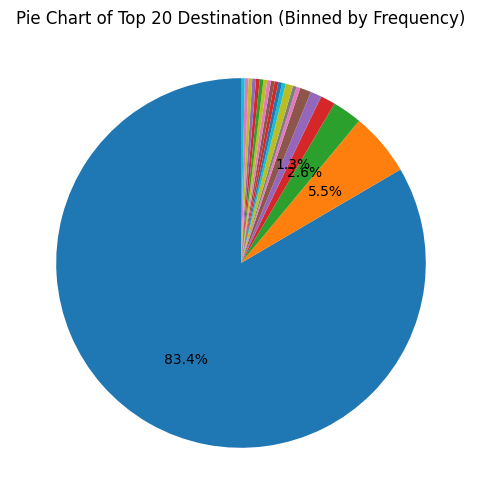

In [ ]:
top_sources = df['Destination'].value_counts()

binned = pd.cut(top_sources.values, bins=1000)
binned_counts = pd.Series(binned).value_counts().sort_index()

def autopct_filter(pct):
    return f'{pct:.1f}%' if pct >= 1 else ''

plt.figure(figsize=(6, 6))
plt.pie(
    binned_counts.values,
    labels=None,
    autopct=autopct_filter,
    startangle=90
)
plt.title('Pie Chart of Top 20 Destination (Binned by Frequency)')
plt.show()


* A histogram isn’t suitable for this feature either because of the large number of unique values. However, the pie chart shows that most packets were received by a single unique IP, meaning this IP got the most traffic just like the sender IP.

## Feature Protocol

* This feature is also important for us. We can use it to group the network traffic by their protocols and find out which protocol is used the most. We can also check if any protocol has unusual sender or receiver activity.


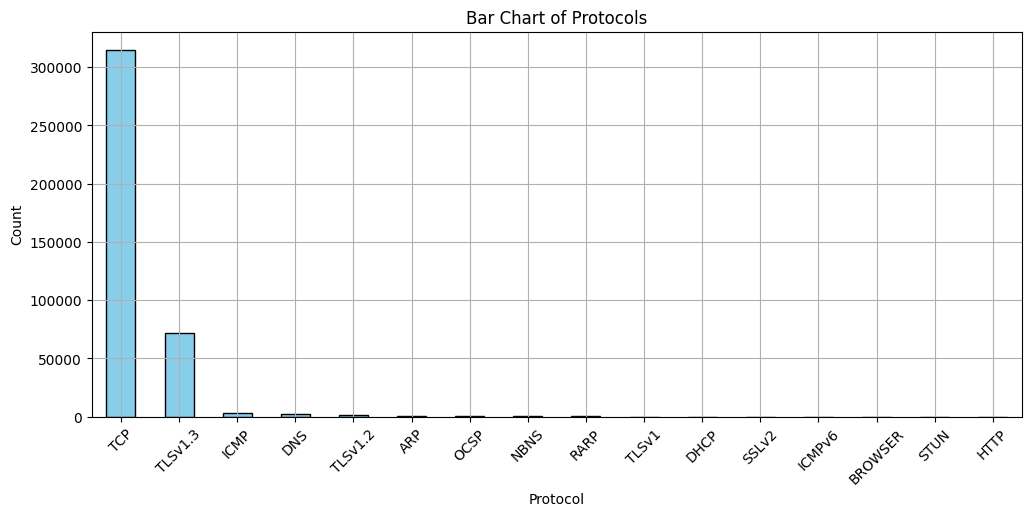

In [ ]:
plt.figure(figsize=(12, 5))

protocol_counts = df['Protocol'].value_counts()
protocol_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Bar Chart of Protocols')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)


* Clearly, TCP and TLSv1.3 are the protocols with the most traffic.


* Protocol Distribution: Different protocols serve distinct purposes. A high volume of specific protocols (e.g., ARP, DNS, ICMP) might indicate network discovery, name resolution, or diagnostic activities. A large presence of application-layer protocols (e.g., HTTP, HTTPS, FTP) suggests user activity or data transfer. Anomalies in protocol distribution can signal network misconfigurations, attacks, or unusual network behavior.

In [ ]:
df.groupby('Protocol')['Length'].describe()

,count,mean,std,min,25%,50%,75%,max
Protocol,,,,,,,,
ARP,447.0,56.134228,7.400149,42.0,60.0,60.0,60.0,60.0
BROWSER,8.0,243.000000,0.000000,243.0,243.0,243.0,243.0,243.0
DHCP,17.0,354.352941,12.757063,339.0,339.0,364.0,364.0,370.0
DNS,1999.0,128.808404,74.316147,63.0,79.0,96.0,158.5,824.0
HTTP,3.0,320.000000,0.000000,320.0,320.0,320.0,320.0,320.0
ICMP,2690.0,93.509294,13.589124,60.0,98.0,98.0,98.0,321.0
ICMPv6,9.0,86.000000,0.000000,86.0,86.0,86.0,86.0,86.0
NBNS,231.0,98.389610,8.631826,92.0,92.0,92.0,110.0,110.0
OCSP,258.0,630.131783,222.455867,416.0,425.5,472.0,791.0,1253.0


* This is the most important analysis we should do. It shows us which protocols have the most sending and receiving activity based on the packet length.

In [ ]:
df.groupby('Protocol')['Length'].mean().sort_values(ascending=False)


,Length
Protocol,
SSLv2,1498.000000
TLSv1.3,1044.865075
TCP,990.323908
OCSP,630.131783
TLSv1.2,577.862734
TLSv1,567.000000
DHCP,354.352941
HTTP,320.000000
BROWSER,243.000000


* For example, SSLv2 has the longest packet length even though it only has 4 records. This way, we can identify which protocols have the most unusual sending and receiving activity.


## Feature: Length

* This shows the length of the packet measured in bytes. The current data type is `int64`, but based on the data, we should convert it to `int32`. This feature is very important. Combining length, protocol, source, and destination could give us great insights.


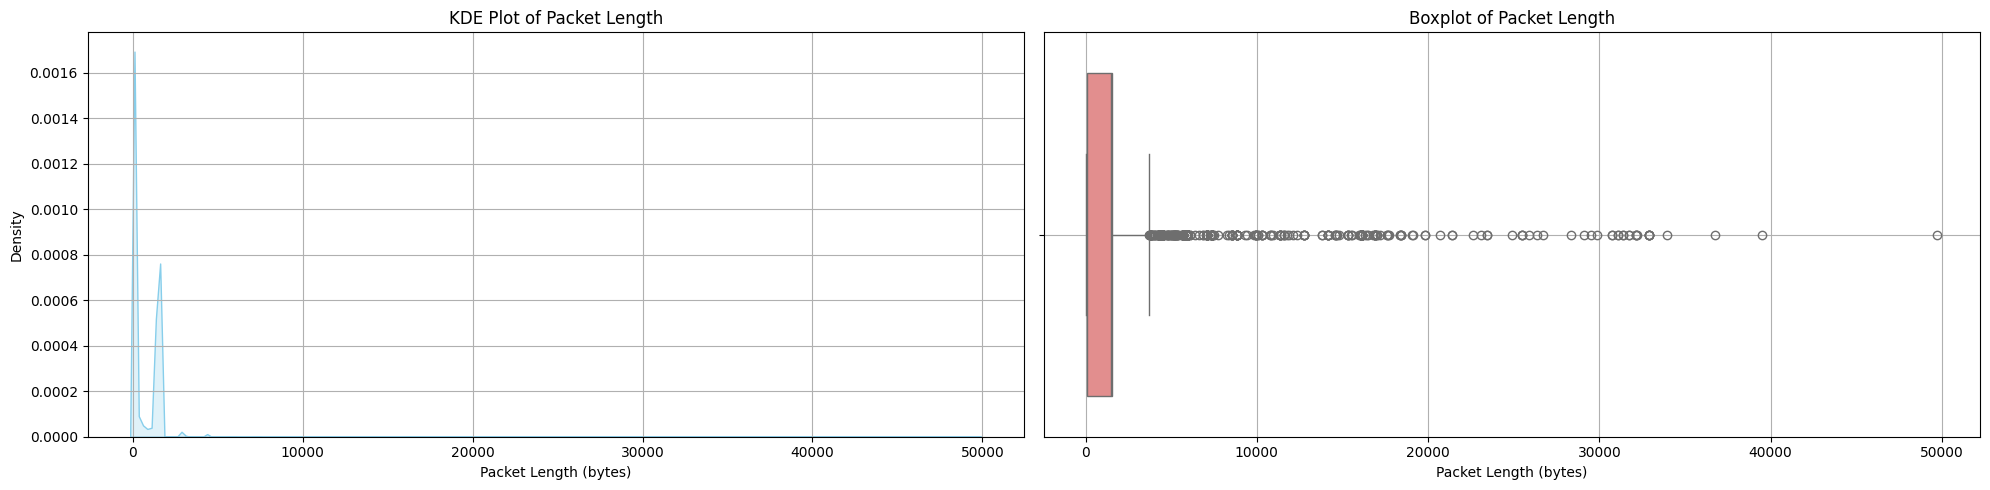

In [ ]:
length_data = df['Length'].dropna()

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(length_data, fill=True, color='skyblue')
plt.title('KDE Plot of Packet Length')
plt.xlabel('Packet Length (bytes)')
plt.ylabel('Density')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x=length_data, color='lightcoral')
plt.title('Boxplot of Packet Length')
plt.xlabel('Packet Length (bytes)')
plt.grid(True)

plt.tight_layout()
plt.show()


* Packet Length Analysis: Packet lengths often vary by protocol and type of data transfer. Small packets might indicate acknowledgments, control messages, or interactive traffic. Large packets usually signify bulk data transfers. Analyzing packet lengths can help identify the nature of data being exchanged and potential fragmentation issues or unusually large packets that might indicate malicious activity.

* Although most of the data have low packet lengths, there are many outliers. This network traffic clearly shows abnormal packet sending and receiving. We only want to identify the abnormal data, so we don’t need to normalize the dataset.


# Feature: Info

* This feature contains unstructured data and only shows what the data is made of.


In [ ]:
df['Info'].nunique()

316837

* We have 316,837 unique values! I don’t think it’s worth analyzing all of them, but one thing we can do is find the most common info in the records.


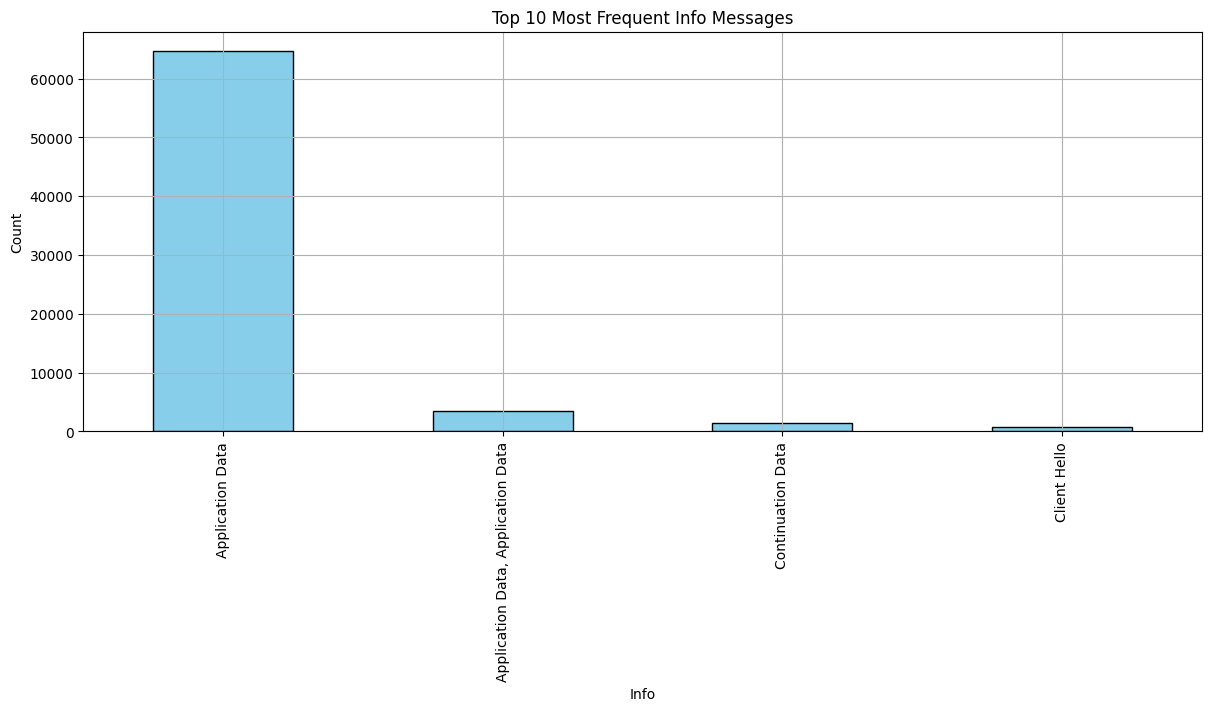

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7), constrained_layout=True)

Info_counts = df['Info'].value_counts().head(4)
Info_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)
ax.set_title('Top 10 Most Frequent Info Messages')
ax.set_xlabel('Info')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(True)

plt.show()


* At first glance, we see that application data is the most common for both IP senders and receivers. However, there are more than 300,000 unique values, which means this is clearly unstructured data.


# Data cleaning

## Changing data types and removing columns

In [ ]:
df['Time'] = df['Time'].astype('float32')

for col in df.columns:
    if col.strip().lower() == 'no.':
        df.drop(columns=col, inplace=True)
        print(f"Removed column: {col}")

df['Length'] = df['Length'].astype('int32')

df.info()
print(df.columns)

Removed column: No.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394136 entries, 0 to 394135
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         394136 non-null  float32
 1   Source       394136 non-null  object 
 2   Destination  394136 non-null  object 
 3   Protocol     394136 non-null  object 
 4   Length       394136 non-null  int32  
 5   Info         394136 non-null  object 
dtypes: float32(1), int32(1), object(4)
memory usage: 15.0+ MB
Index(['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info'], dtype='object')


* Time data type -> float64 changed to float32

* Remove No. column -> meaningless feature

* Length data type -> int64 changed to int32

## Outliers handeling

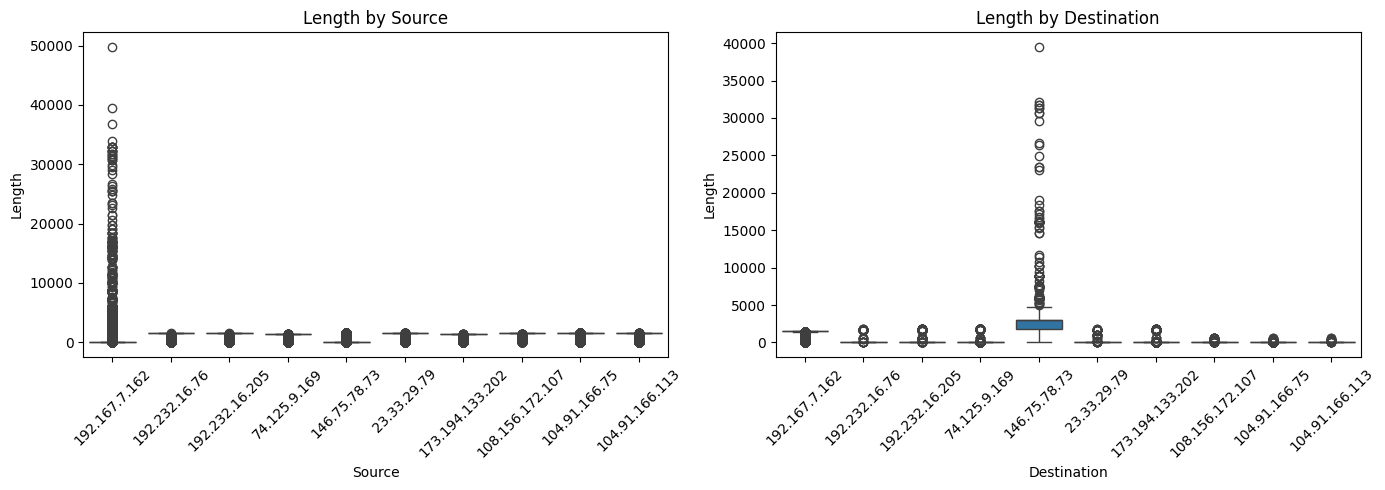

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
top_sources = df['Source'].value_counts().head(10).index
sns.boxplot(x='Source', y='Length', data=df[df['Source'].isin(top_sources)])
plt.title('Length by Source')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
top_destination = df['Destination'].value_counts().head(10).index
sns.boxplot(x='Destination', y='Length', data=df[df['Destination'].isin(top_destination)])
plt.title('Length by Destination')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

* There are many unique source and destination values. I only showed boxplots for the top 10 most common ones in our data.


* It’s clear that two IPs in both the destination and source have the most traffic and the most outliers. This suggests there might be a server attack or a DDoS happening.


## Missing data handeling



In [ ]:
print("\nMissing values in each column:")
print(df.isnull().sum().to_markdown(numalign="left", stralign="left"))


Missing values in each column:
|             | 0   |
|:------------|:----|
| Time        | 0   |
| Source      | 0   |
| Destination | 0   |
| Protocol    | 0   |
| Length      | 0   |
| Info        | 0   |


## Noise handeling
* Noise data doesn’t have a meaning in our dataset because our goal is to find abnormal data that shows server attacks or unusual packets. In this case, the noise is actually the abnormal data we want to find, so we don’t need to remove or handle extreme values.


# **Important data analysis**

## First, I want to show which two IP addresses in the destination and source sections have the highest packet counts.

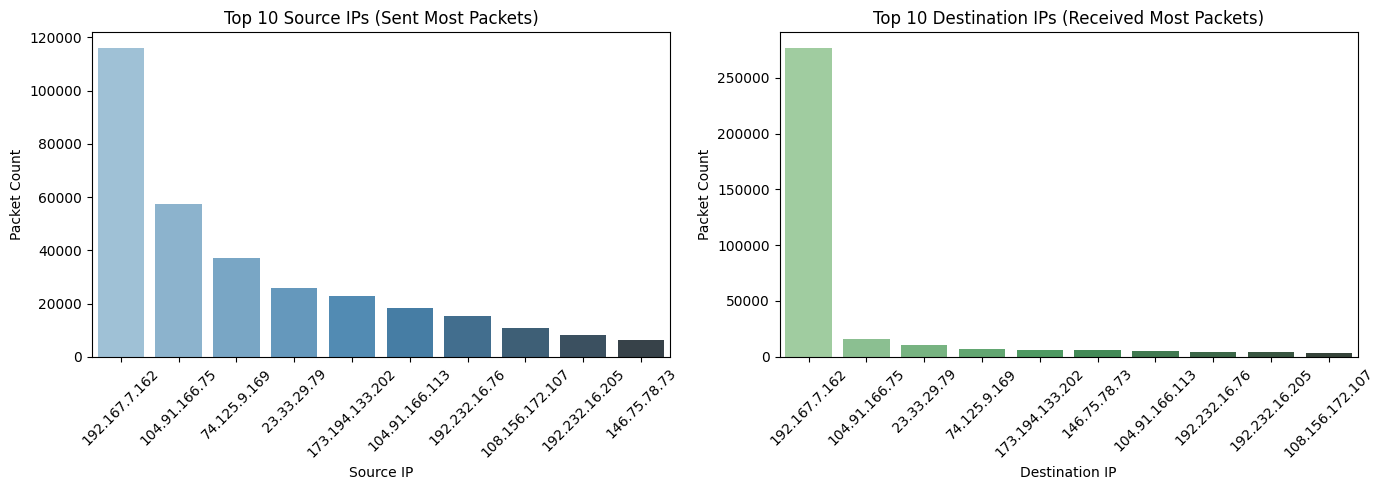

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
top_sources = df['Source'].value_counts().head(10)
sns.barplot(
    x=top_sources.index,
    y=top_sources.values,
    hue=top_sources.index,
    palette='Blues_d',
    legend=False
)
plt.title('Top 10 Source IPs (Sent Most Packets)')
plt.xlabel('Source IP')
plt.ylabel('Packet Count')
plt.xticks(rotation=45)

#--------------------------------------------------#

plt.subplot(1, 2, 2)
top_dest = df['Destination'].value_counts().head(10)
sns.barplot(
    x=top_dest.index,
    y=top_dest.values,
    hue=top_dest.index,
    palette='Greens_d',
    legend=False
)
plt.title('Top 10 Destination IPs (Received Most Packets)')
plt.xlabel('Destination IP')
plt.ylabel('Packet Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


* These plots show us the IP addresses with the most traffic in both the sending and receiving sections.

* Source and Destination Analysis: Identifying the most active source and destination IP addresses or MAC addresses can pinpoint critical servers, heavily used clients, or potential command-and-control centers in a compromised network. Unusual communication patterns warrant further investigation.

## Second, this pair plot shows us the wide range of our dataset and clearly highlights the normal and abnormal records.


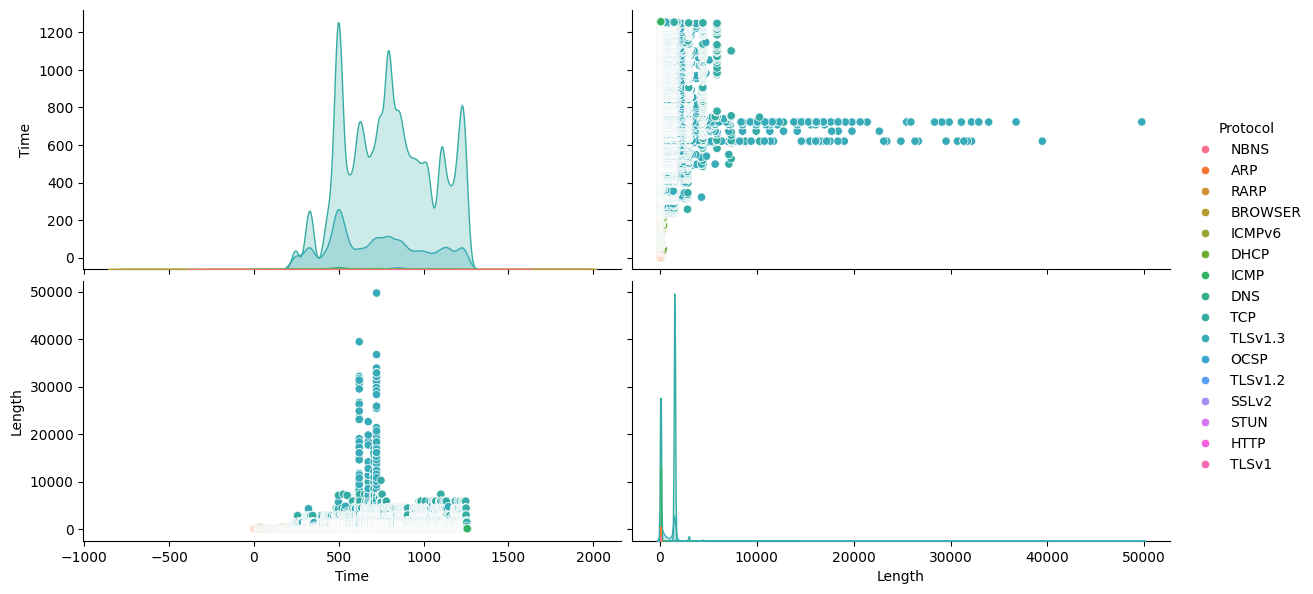

In [ ]:
sns.pairplot(df, hue="Protocol", height=3, aspect=2)

* Also, our data covers an extremely wide range, making the difference between abnormal and normal IP addresses very clear.


## Third, This correlation heatmap shows that there is no significant correlation between our features.


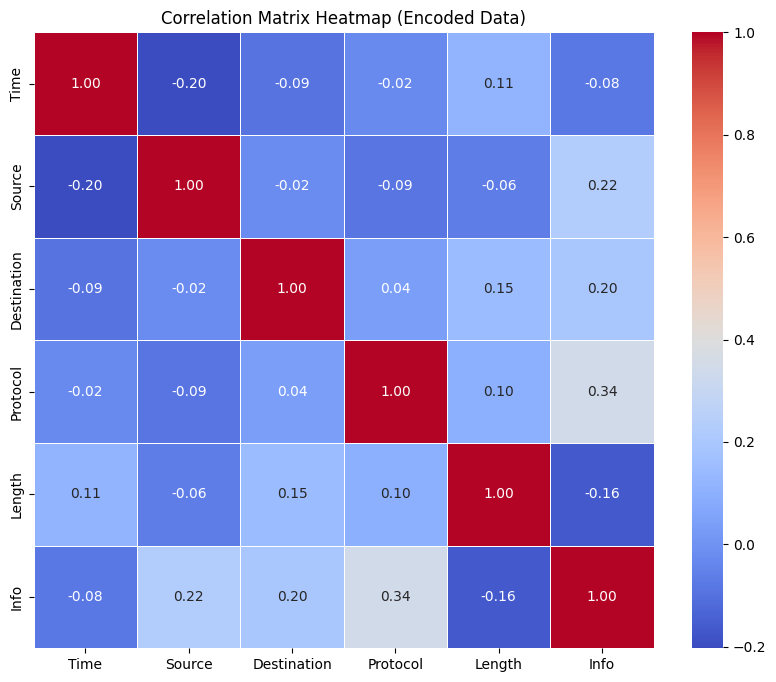

In [ ]:
df_encoded = df.copy()

for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

corr = df_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Encoded Data)')
plt.show()

* Because the data is very unique, the correlation heatmap doesn’t work well, and there are no strongly correlated columns in our dataset.


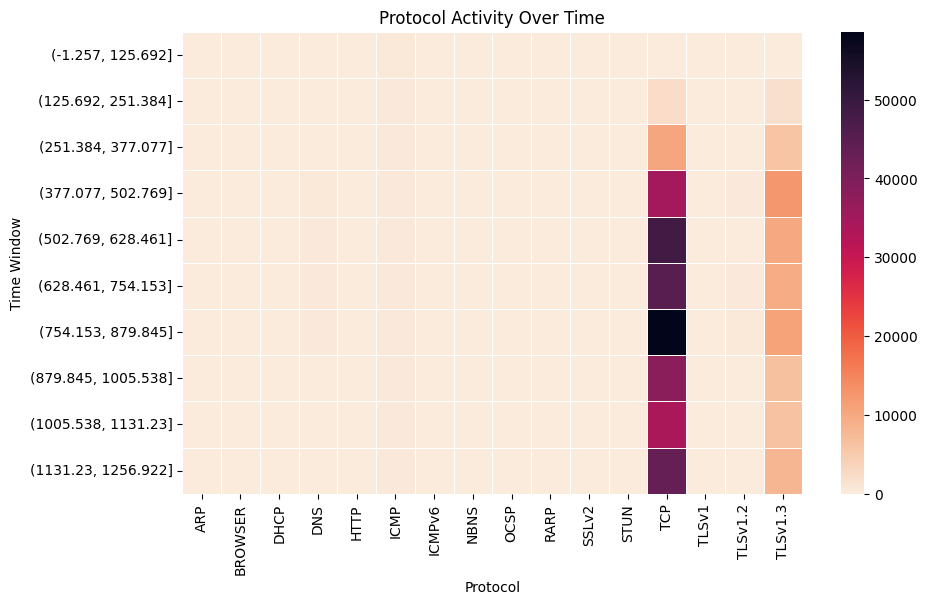

In [ ]:
df['Time_bin'] = pd.cut(df['Time'], bins=10)
proto_time = pd.crosstab(df['Time_bin'], df['Protocol'])

plt.figure(figsize=(10, 6))
sns.heatmap(proto_time, cmap="rocket_r", linewidths=0.5)
plt.title("Protocol Activity Over Time")
plt.xlabel("Protocol")
plt.ylabel("Time Window")
plt.show()

* As you can see, just two of our protocols have abnormal activity and the others are normal.

## Forth, Time-Based Analysis: Understanding traffic patterns over time is crucial for baselining normal network behavior. Peaks in traffic might correspond to specific events.

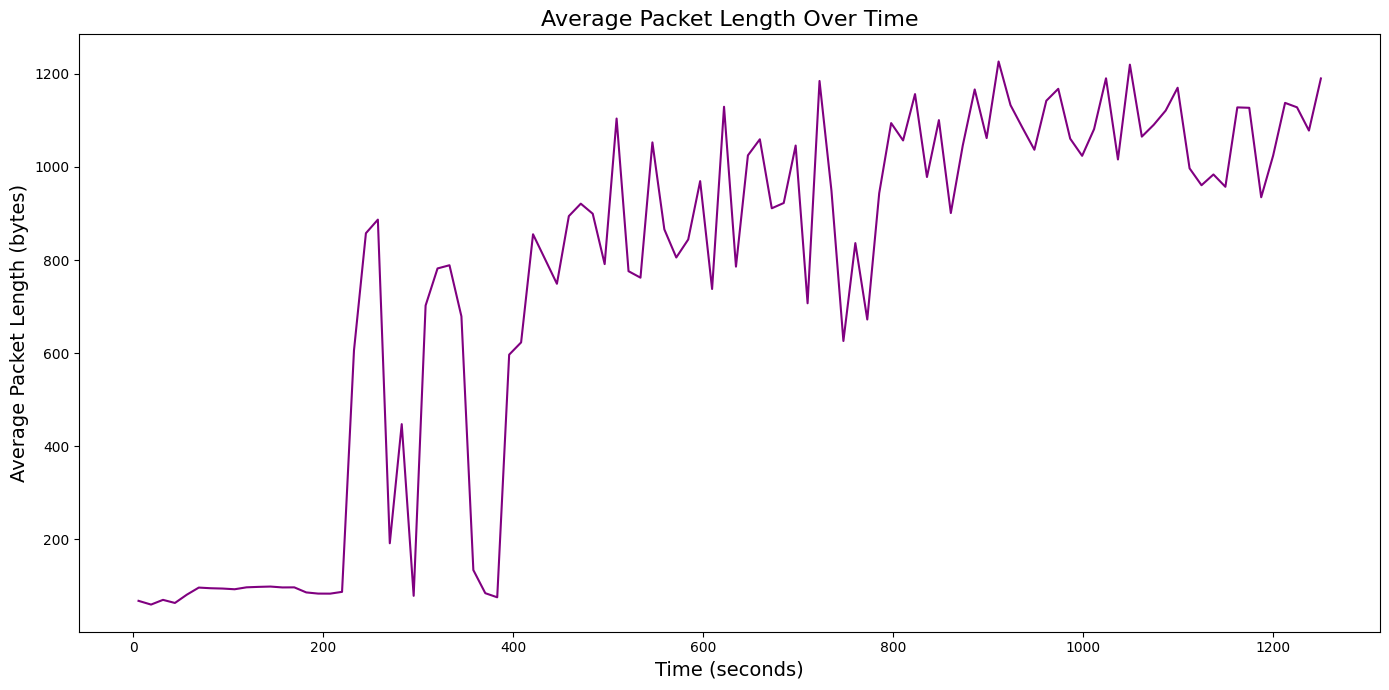

In [ ]:
time_bins = pd.cut(df['Time'], bins=100)
avg_length_over_time = df.groupby(time_bins, observed=False)['Length'].mean().reset_index()
avg_length_over_time['Time_Mid'] = avg_length_over_time['Time'].apply(lambda x: x.mid)

plt.figure(figsize=(14, 7))
sns.lineplot(x='Time_Mid', y='Length', data=avg_length_over_time, color='purple')
plt.title('Average Packet Length Over Time', fontsize=16)
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Average Packet Length (bytes)', fontsize=14)
plt.tight_layout()
plt.show()

## Fifth, Categorzing our packets by there length size

In [ ]:
bins = [0, 100, 500, 1000, df['Length'].max()]
labels = ['Small_Packet', 'Medium_Packet', 'Large_Packet', 'EXTREAM_Packet']

df['Packet_Size_Category'] = pd.cut(df['Length'], bins=bins, labels=labels, right=False)

print("\nExample of 'Packet_Size_Category' feature:")
print(df[['Length', 'Packet_Size_Category']].head().to_markdown(index=False, numalign="left", stralign="left"))
print("\nValue counts for 'Packet_Size_Category':")
print(df['Packet_Size_Category'].value_counts().to_markdown(numalign="left", stralign="left"))


Example of 'Packet_Size_Category' feature:
| Length   | Packet_Size_Category   |
|:---------|:-----------------------|
| 92       | Small_Packet           |
| 92       | Small_Packet           |
| 60       | Small_Packet           |
| 60       | Small_Packet           |
| 60       | Small_Packet           |

Value counts for 'Packet_Size_Category':
| Packet_Size_Category   | count   |
|:-----------------------|:--------|
| EXTREAM_Packet         | 239902  |
| Small_Packet           | 128397  |
| Medium_Packet          | 18055   |
| Large_Packet           | 7781    |


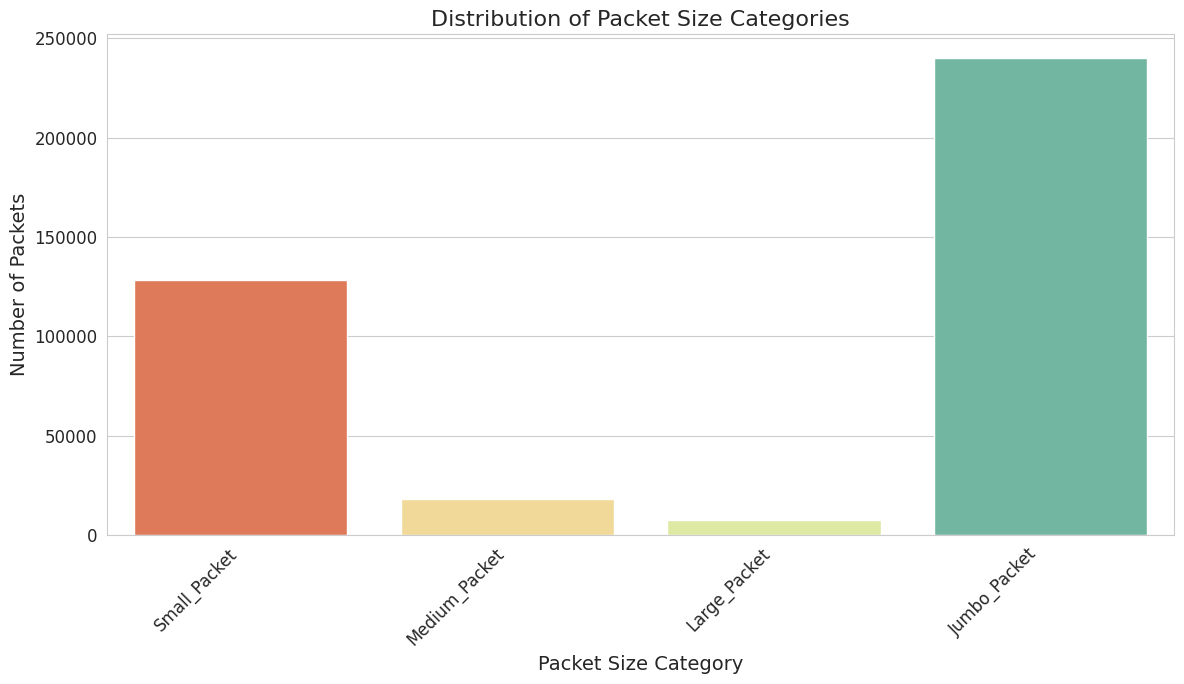

In [ ]:
bins = [0, 100, 500, 1000, df['Length'].max()]
labels = ['Small_Packet', 'Medium_Packet', 'Large_Packet', 'Jumbo_Packet']
df['Packet_Size_Category'] = pd.cut(df['Length'], bins=bins, labels=labels, right=False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

plt.figure(figsize=(12, 7))
sns.countplot(x='Packet_Size_Category', data=df, palette='Spectral', order=labels,
              hue='Packet_Size_Category', legend=False)
plt.title('Distribution of Packet Size Categories', fontsize=16)
plt.xlabel('Packet Size Category', fontsize=14)
plt.ylabel('Number of Packets', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

* Feature: Categorizing Length
Categorizing numerical features like Length into meaningful groups can simplify analysis and highlight the distribution of different types of data transfers. This can differentiate control traffic from bulk data transfers.

## At last, Analyze the distribution of packet sizes across different protocols to identify which protocols carry the highest number of packets, and which protocols account for the largest total volume of data.

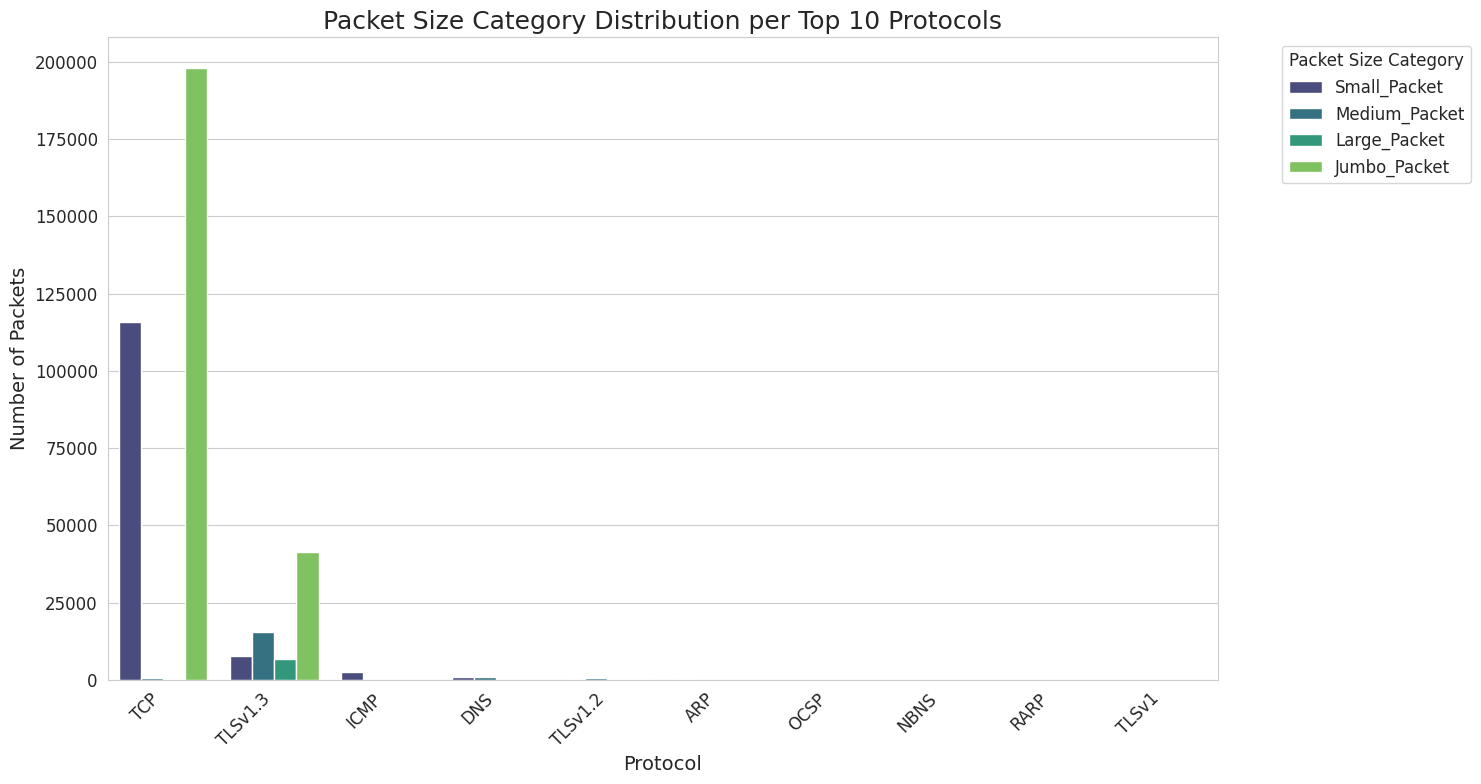

In [ ]:
bins = [0, 100, 500, 1000, df['Length'].max()]
labels = ['Small_Packet', 'Medium_Packet', 'Large_Packet', 'Jumbo_Packet']
df['Packet_Size_Category'] = pd.cut(df['Length'], bins=bins, labels=labels, right=False)

top_n_protocols = df['Protocol'].value_counts().head(10).index.tolist()

df_filtered = df[df['Protocol'].isin(top_n_protocols)].copy()

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (13, 8)
plt.rcParams['font.size'] = 12

plt.figure(figsize=(15, 8))
sns.countplot(x='Protocol', hue='Packet_Size_Category', data=df_filtered,
              palette='viridis', order=top_n_protocols,
              hue_order=labels)

plt.title('Packet Size Category Distribution per Top 10 Protocols', fontsize=18)
plt.xlabel('Protocol', fontsize=14)
plt.ylabel('Number of Packets', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Packet Size Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


* Most of the unusual packets are in TlSv1.3. Tcp is noraml with small and daily packets

# Alireza Kia Tonekaboni’s first Python data analysis project. Special thanks to my instructor, Mr. Ahmad Mesbah, at MFT.